# Data Preprocessing - Amazon Beauty Products Recommendation System

**CSC17104 - Programming for Data Science**  
**Student:** Angela - MSSV: 23122030  
**Notebook:** 02_preprocessing.ipynb

---

## Mục tiêu

Notebook này thực hiện preprocessing dữ liệu Amazon Beauty ratings với các bước:

1. **Xử lý Missing Values** - Phát hiện và xử lý dữ liệu thiếu
2. **Outlier Detection** - Loại bỏ dữ liệu bất thường
3. **Feature Engineering** - Tạo features mới từ dữ liệu hiện có
4. **Normalization/Standardization** - Chuẩn hóa dữ liệu
5. **Data Filtering** - Lọc users/products có ít ratings
6. **Save Processed Data** - Lưu dữ liệu đã xử lý

**Tối ưu hóa:** Tất cả operations đều vectorized (không dùng loops) để chạy nhanh.

---

## 1. Import Libraries và Configuration

In [1]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import sys

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("AMAZON BEAUTY - DATA PREPROCESSING")
print(f"NumPy: {np.__version__}")


AMAZON BEAUTY - DATA PREPROCESSING
NumPy: 1.26.4


## 2. Load Raw Data (Vectorized)

**Kỹ thuật:** Dùng `np.genfromtxt()` để load toàn bộ file một lần (vectorized I/O)

In [2]:
print("Đang đọc dữ liệu thô...")

data_path = '../data/raw/ratings_Beauty.csv'

# Vectorized loading - đọc toàn bộ file một lần
data = np.genfromtxt(
    data_path,
    delimiter=',',
    skip_header=1,
    dtype=None,
    encoding='utf-8',
    names=['UserId', 'ProductId', 'Rating', 'Timestamp']
)

# Extract arrays (vectorized operation)
user_ids = data['UserId']
product_ids = data['ProductId']
ratings = data['Rating'].astype(np.float64)
timestamps = data['Timestamp'].astype(np.int64)

n_records = len(data)

print(f"Số bản ghi: {n_records:,}")
print(f"Kích thước dữ liệu: {data.shape}")
print("Cột: UserId, ProductId, Rating, Timestamp")


Đang đọc dữ liệu thô...
Số bản ghi: 2,023,070
Kích thước dữ liệu: (2023070,)
Cột: UserId, ProductId, Rating, Timestamp
Số bản ghi: 2,023,070
Kích thước dữ liệu: (2023070,)
Cột: UserId, ProductId, Rating, Timestamp


## 3. Missing Value Analysis (Vectorized)

**Kỹ thuật:** Dùng boolean indexing và `np.sum()` thay vì loop

In [3]:
print("Phân tích missing values...")

nan_ratings = np.isnan(ratings)
nan_timestamps = timestamps == 0  # Timestamp = 0 là invalid

n_nan_ratings = np.sum(nan_ratings)
n_nan_timestamps = np.sum(nan_timestamps)

print(f"Missing:\n  Rating: {n_nan_ratings:,} ({n_nan_ratings/n_records*100:.2f}%)\n  Timestamp: {n_nan_timestamps:,} ({n_nan_timestamps/n_records*100:.2f}%)")

valid_mask = ~nan_ratings & ~nan_timestamps

if np.sum(~valid_mask) > 0:
    user_ids = user_ids[valid_mask]
    product_ids = product_ids[valid_mask]
    ratings = ratings[valid_mask]
    timestamps = timestamps[valid_mask]
    removed = np.sum(~valid_mask)
    print(f"Đã loại bỏ {removed:,} hàng có missing values; còn {len(ratings):,} bản ghi")
else:
    print("Không có missing values")

n_records = len(ratings)


Phân tích missing values...
Missing:
  Rating: 0 (0.00%)
  Timestamp: 0 (0.00%)
Không có missing values


## 4. Outlier Detection (Vectorized)

**Phương pháp:** 
- Kiểm tra rating range (1.0 - 5.0)
- Kiểm tra timestamp hợp lệ
- Dùng boolean masks cho tất cả operations

In [4]:
print("\n[BƯỚC 3] Phát hiện và xử lý outliers...")

# Rating validation (vectorized comparison)
valid_rating_mask = (ratings >= 1.0) & (ratings <= 5.0)
invalid_ratings = np.sum(~valid_rating_mask)

print(f"\nRating validation:")
print(f"  Range: [{np.min(ratings):.1f}, {np.max(ratings):.1f}]")
print(f"  Invalid ratings (ngoài 1-5): {invalid_ratings:,}")

if invalid_ratings > 0:
    # Vectorized filtering
    user_ids = user_ids[valid_rating_mask]
    product_ids = product_ids[valid_rating_mask]
    ratings = ratings[valid_rating_mask]
    timestamps = timestamps[valid_rating_mask]
    print(f"  ✓ Đã loại bỏ {invalid_ratings:,} ratings không hợp lệ")

# Timestamp validation (vectorized)
min_timestamp = 946684800   # 2000-01-01 00:00:00
max_timestamp = 1704067200  # 2024-01-01 00:00:00
valid_ts_mask = (timestamps >= min_timestamp) & (timestamps <= max_timestamp)
invalid_timestamps = np.sum(~valid_ts_mask)

print(f"\nTimestamp validation:")
print(f"  Valid range: 2000-01-01 to 2024-01-01")
print(f"  Invalid timestamps: {invalid_timestamps:,}")

if invalid_timestamps > 0:
    user_ids = user_ids[valid_ts_mask]
    product_ids = product_ids[valid_ts_mask]
    ratings = ratings[valid_ts_mask]
    timestamps = timestamps[valid_ts_mask]
    print(f"  Đã loại bỏ {invalid_timestamps:,} timestamps không hợp lệ")

print(f"\nSau khi xử lý outliers: {len(ratings):,} bản ghi")


[BƯỚC 3] Phát hiện và xử lý outliers...

Rating validation:
  Range: [1.0, 5.0]
  Invalid ratings (ngoài 1-5): 0

Timestamp validation:
  Valid range: 2000-01-01 to 2024-01-01
  Invalid timestamps: 7
  Đã loại bỏ 7 timestamps không hợp lệ

Sau khi xử lý outliers: 2,023,063 bản ghi


## 5. Feature Engineering (Vectorized)

**Features mới:**
1. **User features** - Tính toán cho mỗi user (vectorized groupby)
2. **Product features** - Tính toán cho mỗi product
3. **Temporal features** - Extract từ timestamp
4. **Interaction features** - User-product interactions

In [5]:
print("Feature engineering (vectorized)...")

# ===== 5.1: User Features (Vectorized) =====
print("5.1 User Features:")

unique_users, user_inverse = np.unique(user_ids, return_inverse=True)
n_users = len(unique_users)

user_rating_counts = np.bincount(user_inverse)
user_rating_sums = np.bincount(user_inverse, weights=ratings)
user_avg_ratings = user_rating_sums / np.maximum(user_rating_counts, 1)
user_rating_sq_sums = np.bincount(user_inverse, weights=ratings**2)
user_rating_vars = (user_rating_sq_sums / np.maximum(user_rating_counts, 1)) - user_avg_ratings**2
user_rating_stds = np.sqrt(np.maximum(user_rating_vars, 0))

user_n_ratings = user_rating_counts[user_inverse]
user_mean_rating = user_avg_ratings[user_inverse]
user_std_rating = user_rating_stds[user_inverse]

print(f"Unique users: {n_users:,}")
print("Tạo các feature: user_n_ratings, user_mean_rating, user_std_rating")

# ===== 5.2: Product Features (Vectorized) =====
print("5.2 Product Features:")

unique_products, product_inverse = np.unique(product_ids, return_inverse=True)
n_products = len(unique_products)

product_rating_counts = np.bincount(product_inverse)
product_rating_sums = np.bincount(product_inverse, weights=ratings)
product_avg_ratings = product_rating_sums / np.maximum(product_rating_counts, 1)
product_rating_sq_sums = np.bincount(product_inverse, weights=ratings**2)
product_rating_vars = (product_rating_sq_sums / np.maximum(product_rating_counts, 1)) - product_avg_ratings**2
product_rating_stds = np.sqrt(np.maximum(product_rating_vars, 0))

product_n_ratings = product_rating_counts[product_inverse]
product_mean_rating = product_avg_ratings[product_inverse]
product_std_rating = product_rating_stds[product_inverse]

print(f"Unique products: {n_products:,}")
print("Tạo các feature: product_n_ratings, product_mean_rating, product_std_rating")

# ===== 5.3: Temporal Features (Vectorized) =====
print("5.3 Temporal Features:")

datetime_array = timestamps.astype('datetime64[s]')
years = datetime_array.astype('datetime64[Y]').astype(int) + 1970
months = datetime_array.astype('datetime64[M]').astype(int) % 12 + 1
weekdays = (datetime_array.astype('datetime64[D]').view('int64') - 4) % 7
max_timestamp = np.max(timestamps)
days_since = (max_timestamp - timestamps) / (24 * 3600)
recency_weight = np.exp(-days_since / 365.0)

print("Tạo các feature temporal: year, month, weekday, days_since, recency_weight")

# ===== 5.4: Interaction Features (Vectorized) =====
print("5.4 Interaction Features:")

user_rating_deviation = ratings - user_mean_rating
product_rating_deviation = ratings - product_mean_rating
global_mean_rating = np.mean(ratings)
global_rating_deviation = ratings - global_mean_rating
user_rating_zscore = user_rating_deviation / np.maximum(user_std_rating, 0.01)

print("Tạo các feature interaction: user_rating_deviation, product_rating_deviation, global_rating_deviation, user_rating_zscore")
print(f"Global mean rating: {global_mean_rating:.4f}")
print("Feature engineering hoàn tất")


Feature engineering (vectorized)...
5.1 User Features:
Unique users: 1,210,264
Tạo các feature: user_n_ratings, user_mean_rating, user_std_rating
5.2 Product Features:
Unique users: 1,210,264
Tạo các feature: user_n_ratings, user_mean_rating, user_std_rating
5.2 Product Features:
Unique products: 249,274
Tạo các feature: product_n_ratings, product_mean_rating, product_std_rating
5.3 Temporal Features:
Tạo các feature temporal: year, month, weekday, days_since, recency_weight
5.4 Interaction Features:
Tạo các feature interaction: user_rating_deviation, product_rating_deviation, global_rating_deviation, user_rating_zscore
Global mean rating: 4.1490
Feature engineering hoàn tất
Unique products: 249,274
Tạo các feature: product_n_ratings, product_mean_rating, product_std_rating
5.3 Temporal Features:
Tạo các feature temporal: year, month, weekday, days_since, recency_weight
5.4 Interaction Features:
Tạo các feature interaction: user_rating_deviation, product_rating_deviation, global_rating

## 6. Feature Statistics Visualization

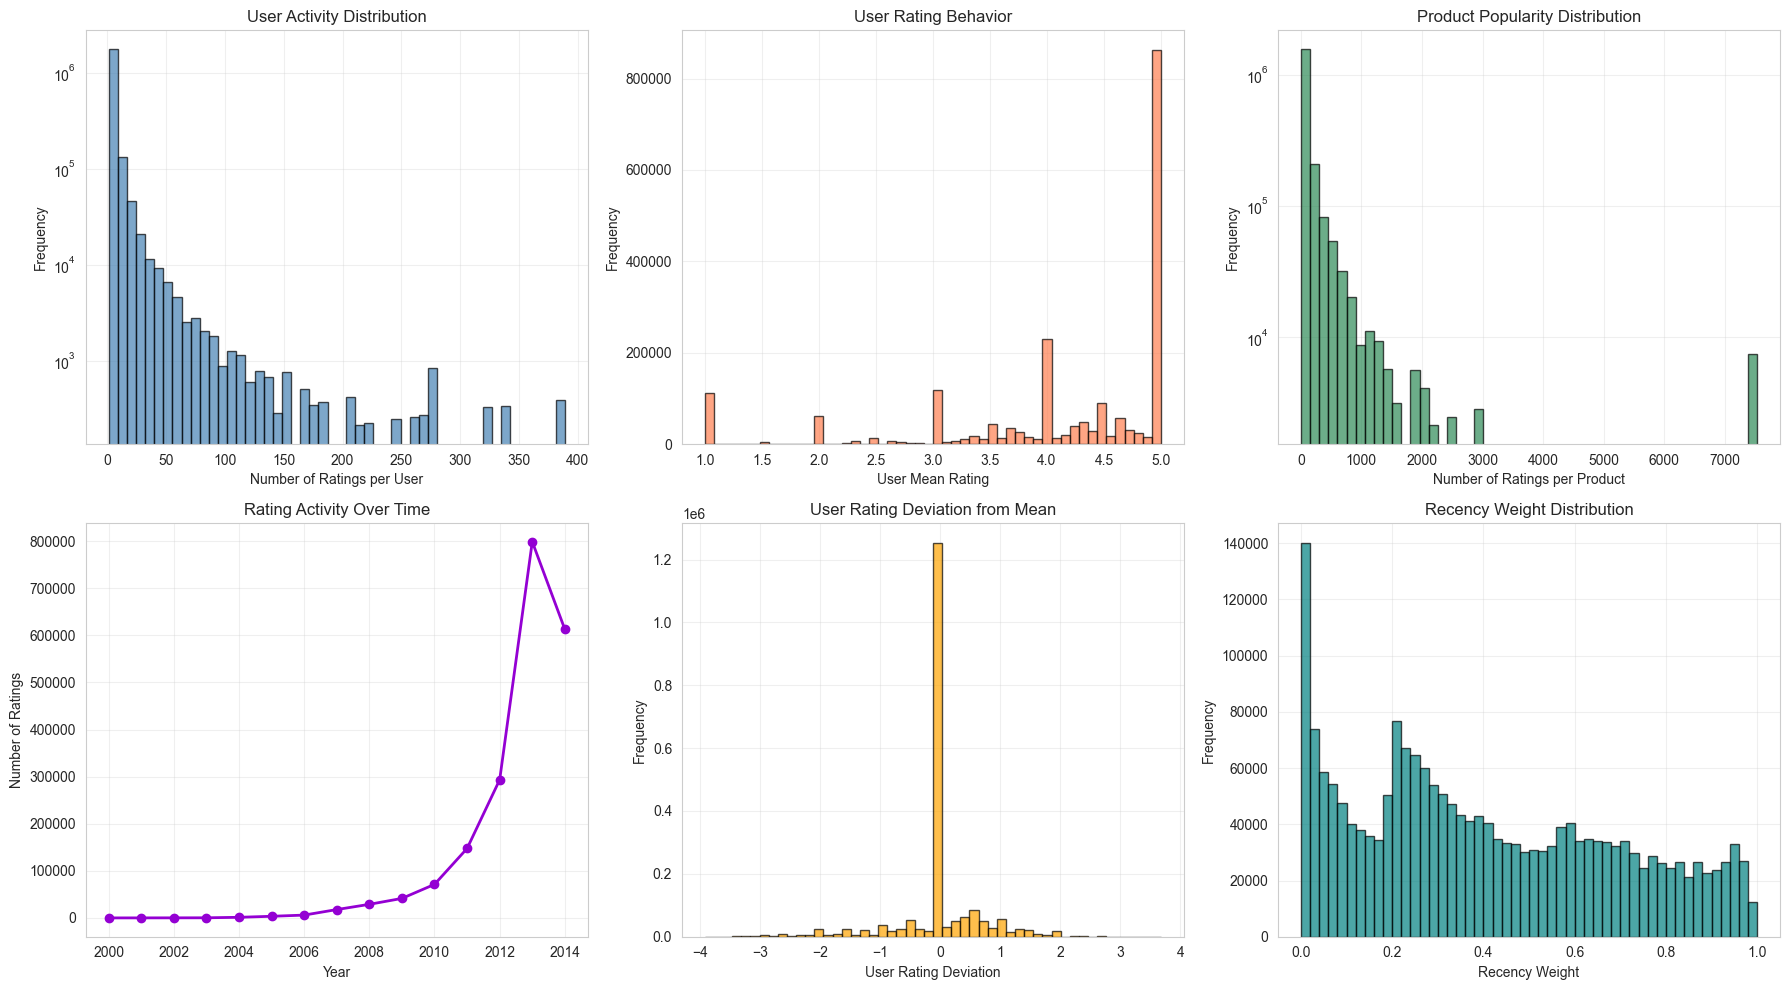

Tóm tắt thống kê feature:
  User ratings: mean=5.51, median=2
  Product ratings: mean=168.37, median=38
  User avg rating: mean=4.149, std=1.112
  Product avg rating: mean=4.149, std=0.619


In [6]:
# Visualize engineered features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# User activity distribution
axes[0, 0].hist(user_n_ratings, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Ratings per User')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('User Activity Distribution')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(alpha=0.3)

# User mean rating distribution
axes[0, 1].hist(user_mean_rating, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('User Mean Rating')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('User Rating Behavior')
axes[0, 1].grid(alpha=0.3)

# Product popularity distribution
axes[0, 2].hist(product_n_ratings, bins=50, color='seagreen', edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Number of Ratings per Product')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Product Popularity Distribution')
axes[0, 2].set_yscale('log')
axes[0, 2].grid(alpha=0.3)

# Temporal trend
year_counts = np.bincount(years - np.min(years))
year_labels = np.arange(np.min(years), np.max(years) + 1)
axes[1, 0].plot(year_labels[:len(year_counts)], year_counts, marker='o', linewidth=2, color='darkviolet')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Number of Ratings')
axes[1, 0].set_title('Rating Activity Over Time')
axes[1, 0].grid(alpha=0.3)

# Rating deviation distribution
axes[1, 1].hist(user_rating_deviation, bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('User Rating Deviation')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('User Rating Deviation from Mean')
axes[1, 1].grid(alpha=0.3)

# Recency weight distribution
axes[1, 2].hist(recency_weight, bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Recency Weight')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title('Recency Weight Distribution')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Tóm tắt thống kê feature:")
print(f"  User ratings: mean={np.mean(user_n_ratings):.2f}, median={np.median(user_n_ratings):.0f}")
print(f"  Product ratings: mean={np.mean(product_n_ratings):.2f}, median={np.median(product_n_ratings):.0f}")
print(f"  User avg rating: mean={np.mean(user_mean_rating):.3f}, std={np.std(user_mean_rating):.3f}")
print(f"  Product avg rating: mean={np.mean(product_mean_rating):.3f}, std={np.std(product_mean_rating):.3f}")


## 7. Data Normalization (Vectorized)

**Phương pháp:**
1. **Min-Max Normalization** - Scale về [0, 1]
2. **Z-score Standardization** - Mean=0, Std=1
3. **Robust Scaling** - Dùng median và IQR (robust to outliers)

In [ ]:
print("Normalization và standardization...")

# ===== 7.1: Min-Max Normalization (Vectorized) =====
print("7.1 Min-Max Normalization")

def minmax_normalize(x):
    """Vectorized Min-Max normalization về [0, 1]"""
    x_min = np.min(x)
    x_max = np.max(x)
    if x_max - x_min == 0:
        return np.zeros_like(x)
    return (x - x_min) / (x_max - x_min)

def zscore_standardize(x):
    """Vectorized Z-score standardization"""
    mean = np.mean(x)
    std = np.std(x)
    if std == 0:
        return np.zeros_like(x)
    return (x - mean) / std

def robust_scale(x):
    """Vectorized robust scaling dùng median và IQR"""
    median = np.median(x)
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    if iqr == 0:
        return np.zeros_like(x)
    return (x - median) / iqr

# Min-Max normalization
user_n_ratings_norm = minmax_normalize(user_n_ratings.astype(np.float64))
product_n_ratings_norm = minmax_normalize(product_n_ratings.astype(np.float64))
days_since_norm = minmax_normalize(days_since)

print(f"  user_n_ratings_norm: [{np.min(user_n_ratings_norm):.3f}, {np.max(user_n_ratings_norm):.3f}]")
print(f"  product_n_ratings_norm: [{np.min(product_n_ratings_norm):.3f}, {np.max(product_n_ratings_norm):.3f}]")
print(f"  days_since_norm: [{np.min(days_since_norm):.3f}, {np.max(days_since_norm):.3f}]")

# Z-score standardization
print("\n7.2 Z-score Standardization")
ratings_std = zscore_standardize(ratings)
user_mean_rating_std = zscore_standardize(user_mean_rating)
product_mean_rating_std = zscore_standardize(product_mean_rating)

print(f"  ratings_std: mean={np.mean(ratings_std):.3f}, std={np.std(ratings_std):.3f}")
print(f"  user_mean_rating_std: mean={np.mean(user_mean_rating_std):.3f}, std={np.std(user_mean_rating_std):.3f}")
print(f"  product_mean_rating_std: mean={np.mean(product_mean_rating_std):.3f}, std={np.std(product_mean_rating_std):.3f}")

# Robust scaling
print("\n7.3 Robust Scaling")
user_n_ratings_robust = robust_scale(user_n_ratings.astype(np.float64))
product_n_ratings_robust = robust_scale(product_n_ratings.astype(np.float64))

print(f"  user_n_ratings_robust: [{np.min(user_n_ratings_robust):.3f}, {np.max(user_n_ratings_robust):.3f}]")
print(f"  product_n_ratings_robust: [{np.min(product_n_ratings_robust):.3f}, {np.max(product_n_ratings_robust):.3f}]")

Normalization và standardization...
7.1 Min-Max Normalization
  user_n_ratings_norm: [0.000, 1.000]
  product_n_ratings_norm: [0.000, 1.000]
  days_since_norm: [0.000, 1.000]


## 8. Data Filtering (Vectorized)

**Mục đích:** Giảm sparsity bằng cách loại bỏ users/products có quá ít ratings

**Strategy:**
- Filter users với < min_user_ratings
- Filter products với < min_product_ratings
- Iterative filtering cho đến khi stable

In [8]:
print("\n[BƯỚC 6] Data Filtering để giảm sparsity...")

# Thresholds
MIN_USER_RATINGS = 5    # User phải có ít nhất 5 ratings
MIN_PRODUCT_RATINGS = 5  # Product phải có ít nhất 5 ratings

print(f"\nFiltering criteria:")
print(f"  - Min ratings per user: {MIN_USER_RATINGS}")
print(f"  - Min ratings per product: {MIN_PRODUCT_RATINGS}")

# Before filtering stats
print(f"\nBefore filtering:")
print(f"  - Records: {len(ratings):,}")
print(f"  - Users: {len(np.unique(user_ids)):,}")
print(f"  - Products: {len(np.unique(product_ids)):,}")

# Iterative filtering (vectorized)
iteration = 0
prev_n_records = len(ratings)

while True:
    iteration += 1
    
    # Count ratings per user (vectorized)
    unique_users_temp, user_inverse_temp = np.unique(user_ids, return_inverse=True)
    user_counts_temp = np.bincount(user_inverse_temp)
    
    # Count ratings per product (vectorized)
    unique_products_temp, product_inverse_temp = np.unique(product_ids, return_inverse=True)
    product_counts_temp = np.bincount(product_inverse_temp)
    
    # Create masks (vectorized)
    user_valid = user_counts_temp[user_inverse_temp] >= MIN_USER_RATINGS
    product_valid = product_counts_temp[product_inverse_temp] >= MIN_PRODUCT_RATINGS
    
    # Combined mask
    valid_mask = user_valid & product_valid
    
    # Apply filter (vectorized)
    user_ids = user_ids[valid_mask]
    product_ids = product_ids[valid_mask]
    ratings = ratings[valid_mask]
    timestamps = timestamps[valid_mask]
    
    # Update all feature arrays
    user_n_ratings = user_n_ratings[valid_mask]
    user_mean_rating = user_mean_rating[valid_mask]
    user_std_rating = user_std_rating[valid_mask]
    product_n_ratings = product_n_ratings[valid_mask]
    product_mean_rating = product_mean_rating[valid_mask]
    product_std_rating = product_std_rating[valid_mask]
    years = years[valid_mask]
    months = months[valid_mask]
    weekdays = weekdays[valid_mask]
    days_since = days_since[valid_mask]
    recency_weight = recency_weight[valid_mask]
    user_rating_deviation = user_rating_deviation[valid_mask]
    product_rating_deviation = product_rating_deviation[valid_mask]
    global_rating_deviation = global_rating_deviation[valid_mask]
    user_rating_zscore = user_rating_zscore[valid_mask]
    
    # Normalized features
    user_n_ratings_norm = user_n_ratings_norm[valid_mask]
    product_n_ratings_norm = product_n_ratings_norm[valid_mask]
    days_since_norm = days_since_norm[valid_mask]
    ratings_std = ratings_std[valid_mask]
    user_mean_rating_std = user_mean_rating_std[valid_mask]
    product_mean_rating_std = product_mean_rating_std[valid_mask]
    user_n_ratings_robust = user_n_ratings_robust[valid_mask]
    product_n_ratings_robust = product_n_ratings_robust[valid_mask]
    
    n_removed = prev_n_records - len(ratings)
    print(f"  Iteration {iteration}: Removed {n_removed:,} records")
    
    # Check convergence
    if n_removed == 0:
        print(f"  Converged after {iteration} iterations")
        break
    
    prev_n_records = len(ratings)
    
    if iteration > 10:
        print(f"  ⚠ Max iterations reached")
        break

# After filtering stats
final_users = np.unique(user_ids)
final_products = np.unique(product_ids)

print(f"\nAfter filtering:")
print(f"  - Records: {len(ratings):,}")
print(f"  - Users: {len(final_users):,}")
print(f"  - Products: {len(final_products):,}")

# Sparsity calculation
total_possible = len(final_users) * len(final_products)
sparsity = 1 - (len(ratings) / total_possible)
print(f"\nSparsity after filtering: {sparsity:.6f} ({sparsity*100:.4f}%)")
print(f"Density: {(1-sparsity)*100:.6f}%")


[BƯỚC 6] Data Filtering để giảm sparsity...

Filtering criteria:
  - Min ratings per user: 5
  - Min ratings per product: 5

Before filtering:
  - Records: 2,023,063
  - Users: 1,210,264
  - Users: 1,210,264
  - Products: 249,274
  - Products: 249,274


NameError: name 'ratings_std' is not defined

## 9. Create ID Mappings (Vectorized)

**Mục đích:** Map string IDs → integer indices để dùng trong matrix operations

In [ ]:
print("\n[BƯỚC 7] Tạo ID mappings...")

# Create user mapping (vectorized)
unique_users_final, user_indices = np.unique(user_ids, return_inverse=True)
n_users_final = len(unique_users_final)

# Create product mapping (vectorized)
unique_products_final, product_indices = np.unique(product_ids, return_inverse=True)
n_products_final = len(unique_products_final)

print(f"User mapping:")
print(f"  - Original IDs: strings (e.g., '{unique_users_final[0]}')")
print(f"  - Mapped IDs: integers [0, {n_users_final-1}]")
print(f"  - Total users: {n_users_final:,}")

print(f"\nProduct mapping:")
print(f"  - Original IDs: strings (e.g., '{unique_products_final[0]}')")
print(f"  - Mapped IDs: integers [0, {n_products_final-1}]")
print(f"  - Total products: {n_products_final:,}")

print(f"\nID mappings created (vectorized)")

## 10. Summary Statistics

In [ ]:
print("\n" + "="*80)
print("PREPROCESSING SUMMARY")
print("="*80)

print(f"\n1. DATA SIZE:")
print(f"   - Final records: {len(ratings):,}")
print(f"   - Final users: {n_users_final:,}")
print(f"   - Final products: {n_products_final:,}")
print(f"   - Sparsity: {sparsity*100:.4f}%")

print(f"\n2. RATING STATISTICS:")
print(f"   - Mean: {np.mean(ratings):.4f}")
print(f"   - Median: {np.median(ratings):.1f}")
print(f"   - Std: {np.std(ratings):.4f}")
print(f"   - Range: [{np.min(ratings):.1f}, {np.max(ratings):.1f}]")

print(f"\n3. USER STATISTICS:")
unique_u, u_counts = np.unique(user_indices, return_counts=True)
print(f"   - Avg ratings/user: {np.mean(u_counts):.2f}")
print(f"   - Median ratings/user: {np.median(u_counts):.0f}")
print(f"   - Min ratings/user: {np.min(u_counts)}")
print(f"   - Max ratings/user: {np.max(u_counts)}")

print(f"\n4. PRODUCT STATISTICS:")
unique_p, p_counts = np.unique(product_indices, return_counts=True)
print(f"   - Avg ratings/product: {np.mean(p_counts):.2f}")
print(f"   - Median ratings/product: {np.median(p_counts):.0f}")
print(f"   - Min ratings/product: {np.min(p_counts)}")
print(f"   - Max ratings/product: {np.max(p_counts)}")

print(f"\n5. FEATURES CREATED:")
print(f"   - User features: 3 (n_ratings, mean_rating, std_rating)")
print(f"   - Product features: 3 (n_ratings, mean_rating, std_rating)")
print(f"   - Temporal features: 5 (year, month, weekday, days_since, recency_weight)")
print(f"   - Interaction features: 4 (user/product/global deviations, z-score)")
print(f"   - Normalized features: 8")
print(f"   - Total: 23 features")

print(f"\n6. TEMPORAL RANGE:")
min_date = datetime.fromtimestamp(np.min(timestamps)).strftime('%Y-%m-%d')
max_date = datetime.fromtimestamp(np.max(timestamps)).strftime('%Y-%m-%d')
print(f"   - From: {min_date}")
print(f"   - To: {max_date}")
print(f"   - Duration: {(np.max(timestamps) - np.min(timestamps)) / (365.25*24*3600):.1f} years")

print("\n" + "="*80)

## 11. Save Processed Data

In [ ]:
print("\n[BƯỚC 8] Lưu dữ liệu đã xử lý...")

# Create output directory
output_dir = '../data/processed/'
os.makedirs(output_dir, exist_ok=True)

# Save main data (vectorized I/O)
np.savez_compressed(
    os.path.join(output_dir, 'preprocessed_data.npz'),
    user_indices=user_indices,
    product_indices=product_indices,
    ratings=ratings,
    timestamps=timestamps,
    # Original IDs
    user_ids=user_ids,
    product_ids=product_ids,
    # User features
    user_n_ratings=user_n_ratings,
    user_mean_rating=user_mean_rating,
    user_std_rating=user_std_rating,
    # Product features
    product_n_ratings=product_n_ratings,
    product_mean_rating=product_mean_rating,
    product_std_rating=product_std_rating,
    # Temporal features
    years=years,
    months=months,
    weekdays=weekdays,
    days_since=days_since,
    recency_weight=recency_weight,
    # Interaction features
    user_rating_deviation=user_rating_deviation,
    product_rating_deviation=product_rating_deviation,
    global_rating_deviation=global_rating_deviation,
    user_rating_zscore=user_rating_zscore,
    # Normalized features
    user_n_ratings_norm=user_n_ratings_norm,
    product_n_ratings_norm=product_n_ratings_norm,
    days_since_norm=days_since_norm,
    ratings_std=ratings_std,
    user_mean_rating_std=user_mean_rating_std,
    product_mean_rating_std=product_mean_rating_std,
    user_n_ratings_robust=user_n_ratings_robust,
    product_n_ratings_robust=product_n_ratings_robust
)

# Save mappings
np.savez_compressed(
    os.path.join(output_dir, 'id_mappings.npz'),
    unique_users=unique_users_final,
    unique_products=unique_products_final
)

# Save metadata
metadata = {
    'n_records': len(ratings),
    'n_users': n_users_final,
    'n_products': n_products_final,
    'sparsity': float(sparsity),
    'global_mean_rating': float(global_mean_rating),
    'min_user_ratings': MIN_USER_RATINGS,
    'min_product_ratings': MIN_PRODUCT_RATINGS
}

np.save(os.path.join(output_dir, 'metadata.npy'), metadata)

print(f"Đã lưu dữ liệu vào: {output_dir}")
print(f"  Files:")
print(f"    - preprocessed_data.npz (compressed, {os.path.getsize(os.path.join(output_dir, 'preprocessed_data.npz')) / 1024**2:.2f} MB)")
print(f"    - id_mappings.npz")
print(f"    - metadata.npy")

print("\n" + "="*80)
print("PREPROCESSING HOÀN TẤT!")
print("="*80)
print("\nCác bước tiếp theo:")
print("  1. Exploratory Data Analysis (EDA) với features mới")
print("  2. Build Popularity-based Recommender")
print("  3. Build Collaborative Filtering (Item-based, User-based)")
print("  4. Build Matrix Factorization (SVD)")
print("  5. Evaluation và Comparison")